In [ ]:
!pip install adlfs
!pip install keras-tuner --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.1/186.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


#### IMPORTS

In [ ]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

from typing import Tuple, List, Optional
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd


# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras_tuner import RandomSearch


#### FUNCTIONS

In [ ]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)


    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df

In [ ]:

def prepare_data(df, targets, scaler_type='standard', drop_cols=['date', 'symbol'], encode_symbol: bool = False):
    """
    Prepares data for ML models by imputing missing values and scaling features.

    Args:
        - df (pd.DataFrame): Full input DataFrame.
        - targets (list): List of target columns.
        - scaler_type (str): 'standard' or 'minmax'.
        - drop_cols (list): Columns to drop from the DataFrame.
        - encode_symbol (bool): Whether to keep and encode 'symbol' as a feature.

    Returns:
        - df_scaled (pd.DataFrame): Scaled features with targets.
        - scaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Opcionalmente preservar 'symbol' si se desea codificarlo
    if encode_symbol and 'symbol' in df_clean.columns:
        drop_cols = [col for col in drop_cols if col != 'symbol']

    # Eliminar columnas no deseadas
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Codificar variables categóricas (incluido symbol si se conserva)
    for col in df_clean.select_dtypes(include=['object', 'category']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    # Separar features y targets
    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Imputación de valores
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Escalado
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Reconstruir DataFrame escalado
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

    # Agregar los targets de nuevo
    df_scaled = pd.concat([df_scaled, y], axis=1)

    return df_scaled, scaler



In [ ]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float]:
    """
    Evaluates the classification model and plots the metrics
    Args:
        - y_test (pd.Series): True target vals
        - y_pred (pd.Series): Predicted class vals
        - y_prov (pd.Series): Predicted probss for clas 1
    Returns:
        -  Accuracy, F1 Score, ROC AUC, Confusion Matrix, Precision, Recall.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precission = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n {cm}")
    print(f"Precision: {precission:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc,cm,precission,recall



In [ ]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
  """
  Cleans a DataFrame by dropping unnecessary columns and handling missing values.

  Args:
      df (pd.DataFrame): Input DataFrame.

  Returns:
      pd.DataFrame: Cleaned DataFrame.
  """
  columns_to_drop = [
      'date', 'symbol', 'capital_gains',
      'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
      'price_lead_3m', 'price_lead_6m', 'price_lead_1y',
      'open_v', 'high', 'low', 'dividends', 'stock_splits',
      'is_dividend_day', 'is_stock_split', 'gap_open', 'price_range',
      'tr_1', 'tr_2', 'tr_3', 'sma_5', 'bollinger_upper',
      'bollinger_lower', 'ema_12', 'macd_line'
  ]
  print(f"Shape before: {df.shape}")
  df = df.drop(columns=columns_to_drop, errors='ignore').copy()
  numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
  imputer = SimpleImputer(strategy="mean")
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
  print(f"Shape after: {df.shape}")
  return df


In [ ]:
def build_and_split_sequences(df, target_column, sequence_length=20, test_size=0.2):
    """
    Builds sequential data and splits it into train/test sets.

    Args:
        df (pd.DataFrame): Processed DataFrame with target column.
        target_column (str): Column name for target variable.
        sequence_length (int): Number of time steps per sequence.
        test_size (float): Fraction of data to use for testing.

    Returns:
        X_train, X_test, y_train, y_test
    """
    targets = ["target_3m", "target_6m", "target_1y"]
    feature_cols = [col for col in df.columns if col not in targets]
    print(f"feature_cols:{feature_cols}")

    data = df[feature_cols + [target_column]].copy()
    data[target_column] = (data[target_column] > 0).astype(int)

    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_column]).values.astype(np.float32)
        label = data.iloc[i+sequence_length][target_column]
        X.append(seq)
        y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    return train_test_split(X, y, test_size=test_size, shuffle=False)

In [ ]:
def train_base_lstm_classifier_lite(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=20,
    epochs=30,
    batch_size=32,
    patience=4,
    class_weight=None  # 👈 añadido aquí
):
    """
    Trains a lightweight LSTM classifier on provided data.

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test labels.
        y_prob (np.ndarray): Predicted probabilities.
        y_pred (np.ndarray): Predicted binary classes.
    """

    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC()]
    )

    early_stop = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight  # 👈 se aplica aquí
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


In [ ]:
def train_improved_lstm_classifier_1(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=20,
    epochs=40,
    batch_size=64,
    patience=6,
    learning_rate=5e-5,
    class_weight=None
):
    """
    Trains an enhanced LSTM classifier with more regularization and better generalization.
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


In [ ]:
def train_improved_lstm_classifier_2(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=20,
    epochs=40,
    batch_size=64,
    patience=6,
    learning_rate=3e-5,
    class_weight=None
):
    """
    LSTM model with Bidirectional layers and higher dropout for regularization.
    """

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


In [ ]:
def train_base_gru_classifier_lite(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=20,
    epochs=30,
    batch_size=32,
    patience=4,
    learning_rate=1e-4,
    class_weight=None
):
    """
    Lightweight GRU classifier with dropout and early stopping.
    """

    model = Sequential([
        GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc"), Precision(name="precision"), Recall(name="recall")]
    )

    early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=patience, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


#**MAIN**

In [ ]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']

# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)
df_full = df_full.dropna(subset=['ret_next_3m', 'ret_next_6m', 'ret_next_1y'])

#Addtargets
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.10).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.10).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.10).astype(int)

folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

<ipython-input-14-bfefdc855dfa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["target_3m"] = (df_full["ret_next_3m"] > 0.10).astype(int)


In [ ]:
print(df_full["target_3m"].value_counts())


target_3m
0    7475299
1    3371248
Name: count, dtype: int64


#### **2. Train train_base_lstm_classifier_lite for 20 symbols**

Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5390 - auc: 0.5371 - loss: 0.6899 - val_accuracy: 0.6324 - val_auc: 0.5650 - val_loss: 0.6478
Epoch 2/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5726 - auc: 0.5787 - loss: 0.6818 - val_accuracy: 0.5161 - val_auc: 0.5700 - val_loss: 0.6848
Epoch 3/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5908 - auc: 0.6027 - loss: 0.6742 - val_accuracy: 0.4433 - val_auc: 0.5676 - val_loss: 0.7294
Epoch 4/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5954 - auc: 0.6111 - loss: 0.6714 - val_accuracy: 0.6450 - val_auc: 0.5826 - val_loss: 0.6463
Epoch 5/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5972 - auc: 0.6136 - loss: 0.6713 - val_accuracy: 0.5407 - val_auc: 0.5730 - val_loss: 0.6789
Epoch 6/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5923 - auc: 0.6084 - loss: 0.6769 - val_accuracy: 0.5612 - val_auc: 0.5775 - val_loss: 0.6725
Epoch 7/30
3136/3136 ━

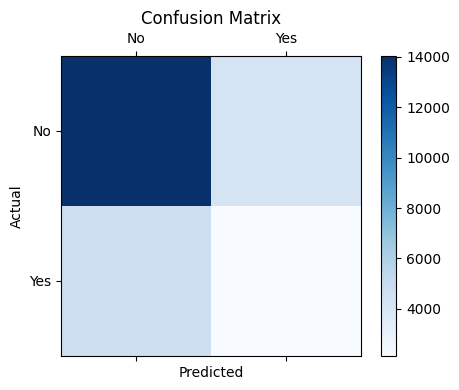

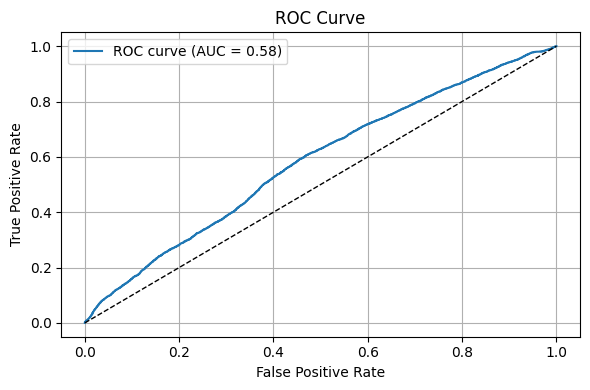

(0.6450043856151823,
 0.3253523261100167,
 np.float64(0.5825541162802603),
 array([[14031,  4216],
        [ 4688,  2147]]),
 0.3374194562313374,
 0.3141185076810534)

In [ ]:
# 20 symbols, target_3m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_3m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.5106 - auc_1: 0.5153 - loss: 0.6939 - val_accuracy: 0.6069 - val_auc_1: 0.4978 - val_loss: 0.6796
Epoch 2/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5356 - auc_1: 0.5418 - loss: 0.6899 - val_accuracy: 0.5291 - val_auc_1: 0.4986 - val_loss: 0.6936
Epoch 3/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5628 - auc_1: 0.5690 - loss: 0.6855 - val_accuracy: 0.4785 - val_auc_1: 0.5169 - val_loss: 0.7164
Epoch 4/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5757 - auc_1: 0.5873 - loss: 0.6816 - val_accuracy: 0.5529 - val_auc_1: 0.5263 - val_loss: 0.6892
Epoch 5/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5748 - auc_1: 0.5826 - loss: 0.6821 - val_accuracy: 0.4261 - val_auc_1: 0.5100 - val_loss: 0.7360
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6069
F1 Score: 0.0724
ROC AUC: 0.4980
Confusion Matrix:
 [[14837   402]
 [ 9458   385]]
Precision: 0.4892
Recall

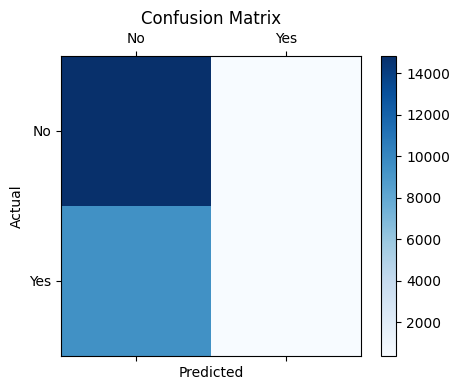

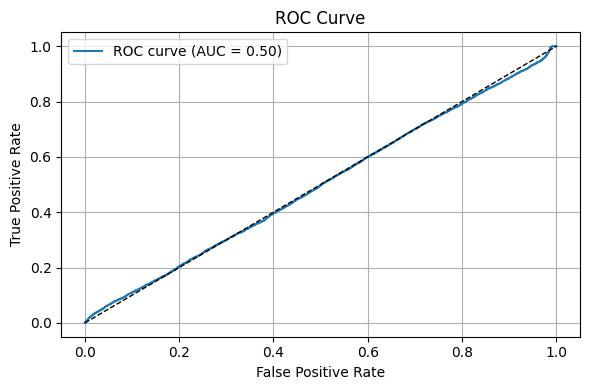

(0.6068894027589506,
 0.07243650047036689,
 np.float64(0.4979674391456598),
 array([[14837,   402],
        [ 9458,   385]]),
 0.4891994917407878,
 0.03911409123234786)

In [ ]:
# 20 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.5242 - auc_2: 0.5362 - loss: 0.6907 - val_accuracy: 0.4781 - val_auc_2: 0.4858 - val_loss: 0.7082
Epoch 2/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5558 - auc_2: 0.5740 - loss: 0.6844 - val_accuracy: 0.4765 - val_auc_2: 0.4823 - val_loss: 0.7249
Epoch 3/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5579 - auc_2: 0.5800 - loss: 0.6819 - val_accuracy: 0.4852 - val_auc_2: 0.4816 - val_loss: 0.7084
Epoch 4/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5703 - auc_2: 0.5940 - loss: 0.6785 - val_accuracy: 0.5004 - val_auc_2: 0.4962 - val_loss: 0.7074
Epoch 5/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5763 - auc_2: 0.6056 - loss: 0.6734 - val_accuracy: 0.4872 - val_auc_2: 0.4750 - val_loss: 0.7102
Epoch 6/30
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5839 - auc_2: 0.6166 - loss: 0.6690 - val_accuracy: 0.5057 - val_auc_2: 0.4973 - val_loss: 0.711

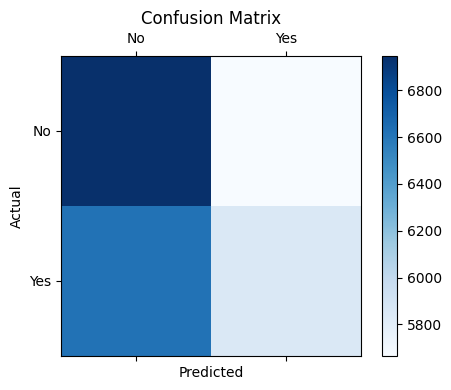

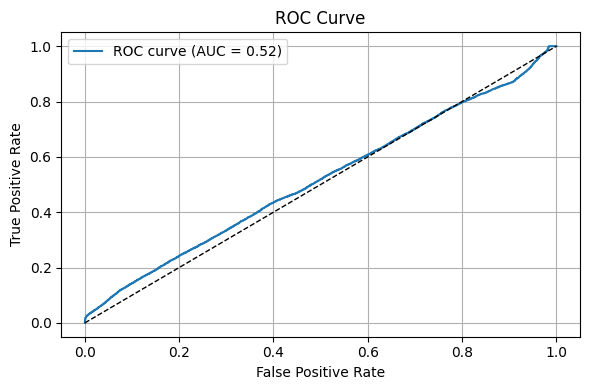

(0.5102463918347819,
 0.4879106219776555,
 np.float64(0.515935424077511),
 array([[6946, 5667],
        [6617, 5852]]),
 0.5080302109558121,
 0.46932392332985806)

In [ ]:
# 20 symbols, target_1y
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_1y'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


#### **3. Train train_base_lstm_classifier_lite for 100 symbols**

Shape before: (622891, 56)
Shape after: (622891, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 118s 7ms/step - accuracy: 0.5426 - auc_3: 0.5572 - loss: 0.6873 - val_accuracy: 0.6554 - val_auc_3: 0.5809 - val_loss: 0.6727
Epoch 2/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.5870 - auc_3: 0.5805 - loss: 0.6818 - val_accuracy: 0.6997 - val_auc_3: 0.5859 - val_loss: 0.6513
Epoch 3/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.5971 - auc_3: 0.5886 - loss: 0.6795 - val_accuracy: 0.6900 - val_auc_3: 0.5886 - val_loss: 0.6493
Epoch 4/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5815 - auc_3: 0.5951 - loss: 0.6779 - val_accuracy: 0.5854 - val_auc_3: 0.5872 - val_loss: 0.6879
Epoch 5/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5866 - auc_3: 0.6003 - loss: 0.6765 - val_accuracy: 0.6593 - val_auc_3: 0.5856 - val_loss: 0.6561
Epoch 6/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5838 - auc_3: 0.6055 - loss: 0.6753 - val_accuracy: 0.5700 - val_auc_3: 0.5896

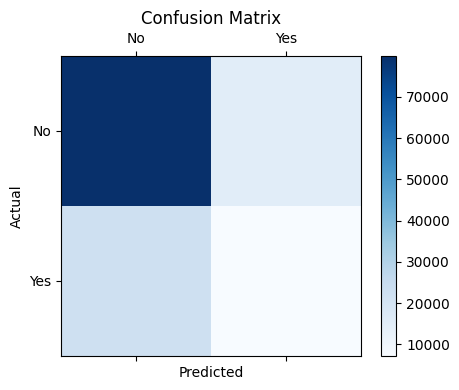

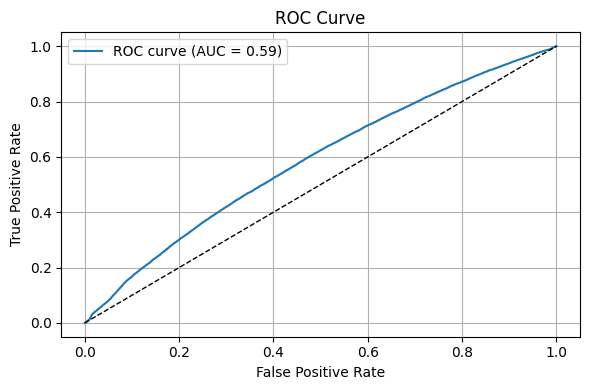

(0.699695746064367,
 0.2801447100026941,
 np.float64(0.586014895281343),
 array([[79880, 15108],
        [22300,  7279]]),
 0.3251440568186894,
 0.24608675073531897)

In [ ]:
# 100 symbols, target_3m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_3m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (622891, 56)
Shape after: (622891, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 118s 7ms/step - accuracy: 0.5254 - auc_4: 0.5376 - loss: 0.6906 - val_accuracy: 0.5115 - val_auc_4: 0.5684 - val_loss: 0.6970
Epoch 2/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.5651 - auc_4: 0.5579 - loss: 0.6872 - val_accuracy: 0.6257 - val_auc_4: 0.5767 - val_loss: 0.6764
Epoch 3/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5664 - auc_4: 0.5646 - loss: 0.6856 - val_accuracy: 0.6245 - val_auc_4: 0.5823 - val_loss: 0.6711
Epoch 4/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5628 - auc_4: 0.5760 - loss: 0.6831 - val_accuracy: 0.5807 - val_auc_4: 0.5858 - val_loss: 0.6815
Epoch 5/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5689 - auc_4: 0.5860 - loss: 0.6807 - val_accuracy: 0.5899 - val_auc_4: 0.5823 - val_loss: 0.6830
Epoch 6/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - accuracy: 0.5668 - auc_4: 0.5916 - loss: 0.6787 - val_accuracy: 0.6124 - val_auc_4: 0.5826

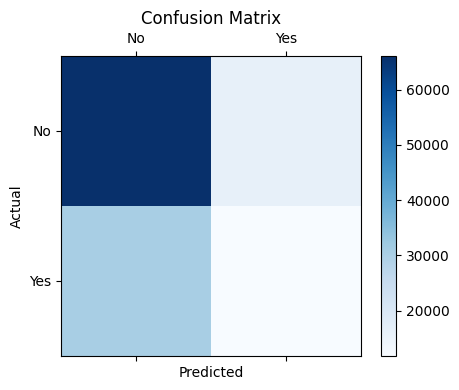

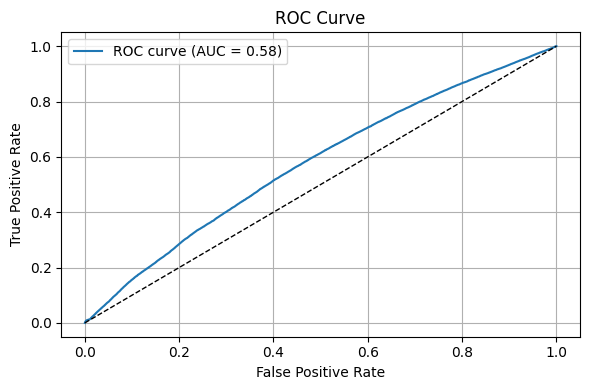

(0.6256873810880892,
 0.3373175480735066,
 np.float64(0.5770013935282643),
 array([[66073, 16221],
        [30406, 11867]]),
 0.42249359156935345,
 0.28072292006718236)

In [ ]:
# 100 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (622891, 56)
Shape after: (622891, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - accuracy: 0.5251 - auc: 0.5392 - loss: 0.6903 - val_accuracy: 0.5728 - val_auc: 0.5789 - val_loss: 0.6865
Epoch 2/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 117s 7ms/step - accuracy: 0.5498 - auc: 0.5624 - loss: 0.6867 - val_accuracy: 0.5725 - val_auc: 0.5815 - val_loss: 0.6824
Epoch 3/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5585 - auc: 0.5802 - loss: 0.6820 - val_accuracy: 0.5664 - val_auc: 0.5874 - val_loss: 0.6824
Epoch 4/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.5682 - auc: 0.5966 - loss: 0.6771 - val_accuracy: 0.5785 - val_auc: 0.5814 - val_loss: 0.6807
Epoch 5/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5739 - auc: 0.6066 - loss: 0.6735 - val_accuracy: 0.5546 - val_auc: 0.5748 - val_loss: 0.6878
Epoch 6/30
15571/15571 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5834 - auc: 0.6174 - loss: 0.6696 - val_accuracy: 0.5845 - val_auc: 0.6103 - val_loss: 0.6796
Epoc

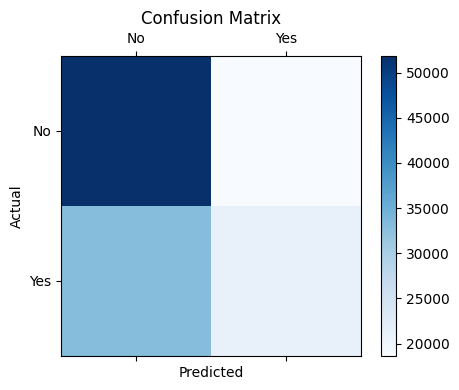

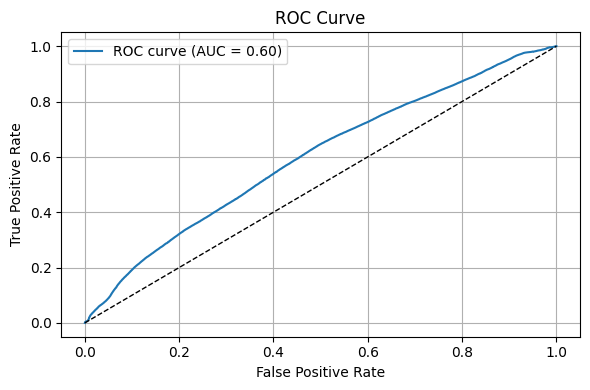

(0.5848820313566193,
 0.44835605624186564,
 np.float64(0.5987889020174623),
 array([[51843, 18667],
        [33043, 21014]]),
 0.5295733474458809,
 0.3887378137891485)

In [ ]:
# 100 symbols, target_1y
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_1y'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


**4.Train train_improved_lstm_classifier_1 for 20 symbols**


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5211 - auc: 0.5196 - loss: 0.7608 - precision: 0.3137 - recall: 0.4965 - val_accuracy: 0.5701 - val_auc: 0.5602 - val_loss: 0.6836 - val_precision: 0.3122 - val_recall: 0.4800
Epoch 2/50
   9/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4918 - auc: 0.4995 - loss: 0.7524 - precision: 0.3067 - recall: 0.4786

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc_18` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5302 - auc: 0.5435 - loss: 0.7141 - precision: 0.3259 - recall: 0.5252 - val_accuracy: 0.6120 - val_auc: 0.5827 - val_loss: 0.6563 - val_precision: 0.3377 - val_recall: 0.4410
Epoch 3/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5397 - auc: 0.5609 - loss: 0.7006 - precision: 0.3378 - recall: 0.5501 - val_accuracy: 0.4716 - val_auc: 0.5670 - val_loss: 0.7317 - val_precision: 0.3029 - val_recall: 0.7217
Epoch 4/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5460 - auc: 0.5635 - loss: 0.6948 - precision: 0.3384 - recall: 0.5406 - val_accuracy: 0.6488 - val_auc: 0.5708 - val_loss: 0.6410 - val_precision: 0.3382 - val_recall: 0.3018
Epoch 5/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5537 - auc: 0.5747 - loss: 0.6908 - precision: 0.3486 - recall: 0.5545 - val_accuracy: 0.5573 - val_auc: 0.5853 - val_loss: 0.6804 - val_precision: 0.3245 - val_recall: 0.5775
Epoch 6/50
1568/1568 ━━━━━━

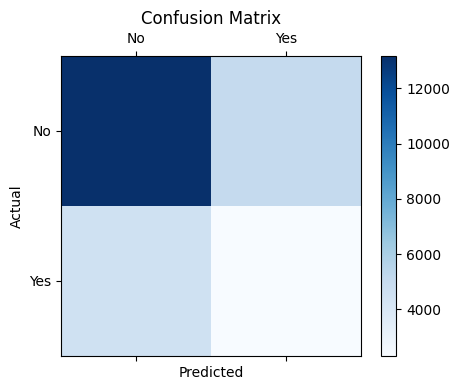

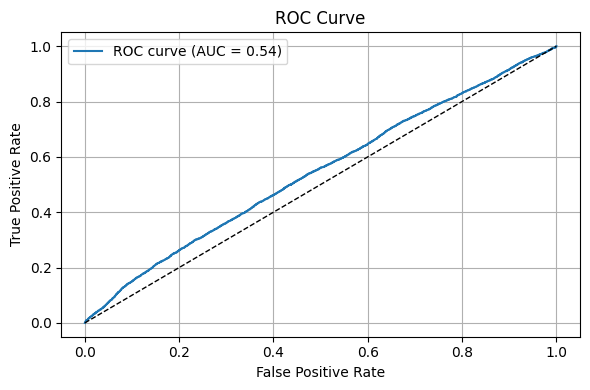

(0.6178135714855275,
 0.3266366957010396,
 np.float64(0.5444126278396557),
 array([[13171,  5076],
        [ 4510,  2325]]),
 0.3141467369274422,
 0.3401609363569861)

In [ ]:
# 20 symbols, target_3m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_3m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5024 - auc: 0.5109 - loss: 0.7380 - precision: 0.4156 - recall: 0.5325 - val_accuracy: 0.5364 - val_auc: 0.5147 - val_loss: 0.6885 - val_precision: 0.4016 - val_recall: 0.3703
Epoch 2/40
   9/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4979 - auc: 0.4887 - loss: 0.7309 - precision: 0.4285 - recall: 0.4634

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc_18` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5109 - auc: 0.5196 - loss: 0.7140 - precision: 0.4235 - recall: 0.5217 - val_accuracy: 0.5053 - val_auc: 0.5272 - val_loss: 0.6982 - val_precision: 0.4097 - val_recall: 0.5911
Epoch 3/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5191 - auc: 0.5297 - loss: 0.7054 - precision: 0.4325 - recall: 0.5331 - val_accuracy: 0.5307 - val_auc: 0.5212 - val_loss: 0.6902 - val_precision: 0.4106 - val_recall: 0.4494
Epoch 4/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5227 - auc: 0.5358 - loss: 0.7009 - precision: 0.4363 - recall: 0.5437 - val_accuracy: 0.5018 - val_auc: 0.5233 - val_loss: 0.7040 - val_precision: 0.4045 - val_recall: 0.5709
Epoch 5/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5321 - auc: 0.5495 - loss: 0.6950 - precision: 0.4430 - recall: 0.5441 - val_accuracy: 0.5513 - val_auc: 0.5290 - val_loss: 0.6917 - val_precision: 0.4264 - val_recall: 0.4153
Epoch 6/40
1568/1568 ━━━━━━

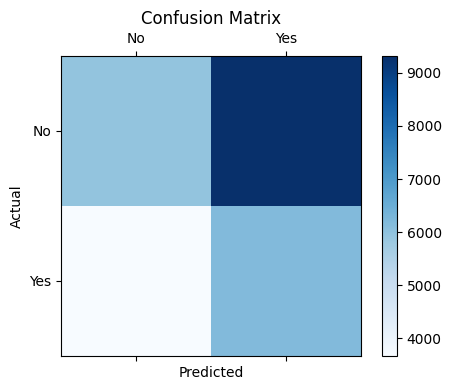

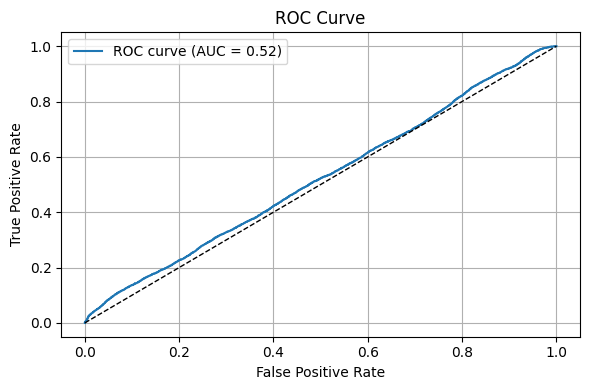

(0.48201897775297026,
 0.4869688832727847,
 np.float64(0.521596173247634),
 array([[5924, 9315],
        [3677, 6166]]),
 0.3982946838059557,
 0.6264350299705375)

In [ ]:
# 20 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5099 - auc: 0.5170 - loss: 0.7364 - precision: 0.5160 - recall: 0.5088 - val_accuracy: 0.4818 - val_auc: 0.4938 - val_loss: 0.7089 - val_precision: 0.4855 - val_recall: 0.7080
Epoch 2/40
   9/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5690 - auc: 0.5950 - loss: 0.6787 - precision: 0.6051 - recall: 0.5862

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc_18` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5305 - auc: 0.5412 - loss: 0.7062 - precision: 0.5375 - recall: 0.5250 - val_accuracy: 0.4985 - val_auc: 0.4947 - val_loss: 0.7041 - val_precision: 0.4958 - val_recall: 0.5231
Epoch 3/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5388 - auc: 0.5544 - loss: 0.6972 - precision: 0.5472 - recall: 0.5503 - val_accuracy: 0.4860 - val_auc: 0.4862 - val_loss: 0.7074 - val_precision: 0.4869 - val_recall: 0.6270
Epoch 4/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5454 - auc: 0.5667 - loss: 0.6912 - precision: 0.5505 - recall: 0.5386 - val_accuracy: 0.4787 - val_auc: 0.5122 - val_loss: 0.7215 - val_precision: 0.4857 - val_recall: 0.8240
Epoch 5/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5555 - auc: 0.5771 - loss: 0.6876 - precision: 0.5603 - recall: 0.5475 - val_accuracy: 0.4856 - val_auc: 0.5046 - val_loss: 0.7191 - val_precision: 0.4889 - val_recall: 0.7648
Epoch 6/40
1568/1568 ━━━━━━

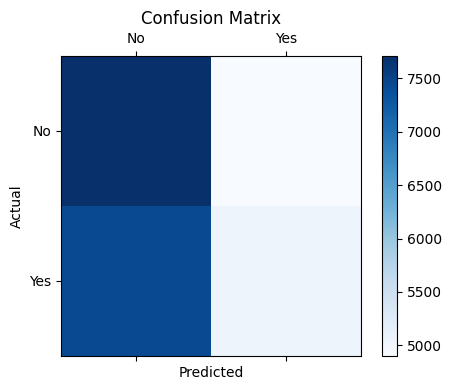

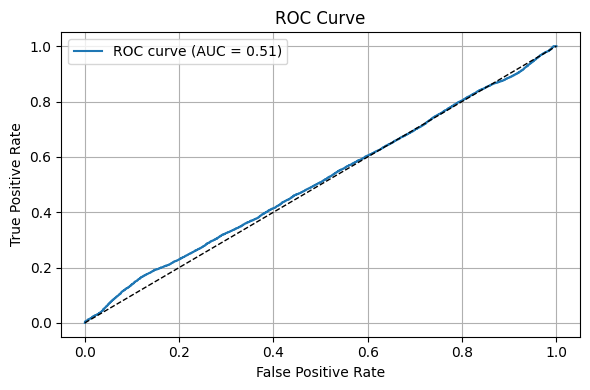

(0.5083326688461846,
 0.44975905764768875,
 np.float64(0.5117581954472017),
 array([[7710, 4903],
        [7429, 5040]]),
 0.5068892688323443,
 0.4042024220065763)

In [ ]:
# 20 symbols, target_1y
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_1y'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


5.Train train_improved_lstm_classifier_2 for 20 symbols

Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.4212 - auc: 0.5001 - loss: 0.8716 - precision: 0.3015 - recall: 0.7021 - val_accuracy: 0.6277 - val_auc: 0.5253 - val_loss: 0.6583 - val_precision: 0.2980 - val_recall: 0.2702
Epoch 2/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5047 - auc: 0.5212 - loss: 0.7674 - precision: 0.3131 - recall: 0.5412 - val_accuracy: 0.6312 - val_auc: 0.5599 - val_loss: 0.6529 - val_precision: 0.3242 - val_recall: 0.3257
Epoch 3/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.5221 - auc: 0.5295 - loss: 0.7451 - precision: 0.3206 - recall: 0.5243 - val_accuracy: 0.6476 - val_auc: 0.5640 - val_loss: 0.6456 - val_precision: 0.3375 - val_recall: 0.3045
Epoch 4/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5260 - auc: 0.5314 - loss: 0.7312 - precision: 0.3187 - recall: 0.5119 - val_accuracy: 0.6097 - val_auc: 0.5584 - val_loss: 0.6628 - val_precision: 0.3121 - val_recall: 0.3590
Epoch 5/40
1568/

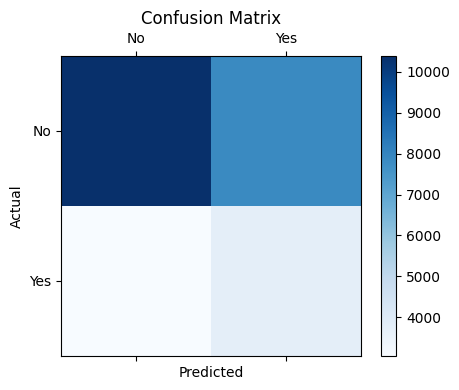

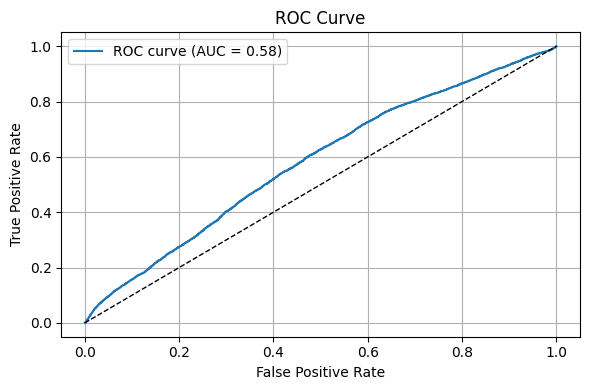

(0.5645482816362332,
 0.40866269626421226,
 np.float64(0.5818247923549598),
 array([[10386,  7861],
        [ 3061,  3774]]),
 0.32436613665663944,
 0.5521580102414045)

In [ ]:
# 20 symbols, target_3m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_3m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.4954 - auc: 0.5059 - loss: 0.8298 - precision: 0.4155 - recall: 0.5517 - val_accuracy: 0.5167 - val_auc: 0.4861 - val_loss: 0.7110 - val_precision: 0.3857 - val_recall: 0.3905
Epoch 2/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5099 - auc: 0.5157 - loss: 0.7715 - precision: 0.4208 - recall: 0.5197 - val_accuracy: 0.5003 - val_auc: 0.4972 - val_loss: 0.7081 - val_precision: 0.3883 - val_recall: 0.4751
Epoch 3/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.5149 - auc: 0.5228 - loss: 0.7462 - precision: 0.4263 - recall: 0.5240 - val_accuracy: 0.5042 - val_auc: 0.5062 - val_loss: 0.7011 - val_precision: 0.3951 - val_recall: 0.4962
Epoch 4/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5222 - auc: 0.5317 - loss: 0.7296 - precision: 0.4317 - recall: 0.5233 - val_accuracy: 0.5024 - val_auc: 0.5029 - val_loss: 0.7039 - val_precision: 0.3930 - val_recall: 0.4925
Epoch 5/40
1568/

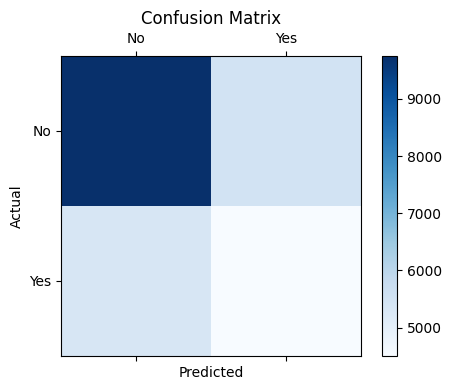

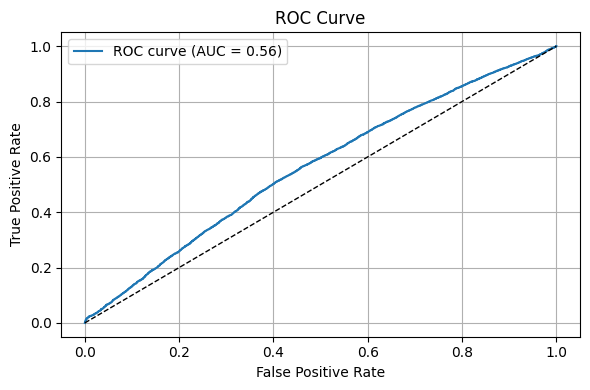

(0.5684953353002153,
 0.4545683616388651,
 np.float64(0.5629488954670885),
 array([[9749, 5490],
        [5333, 4510]]),
 0.451,
 0.4581936401503607)

In [ ]:
# 20 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (125466, 56)
Shape after: (125466, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.5122 - auc: 0.5171 - loss: 0.8527 - precision: 0.5198 - recall: 0.4823 - val_accuracy: 0.4959 - val_auc: 0.4922 - val_loss: 0.7128 - val_precision: 0.4939 - val_recall: 0.5625
Epoch 2/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5128 - auc: 0.5214 - loss: 0.7831 - precision: 0.5183 - recall: 0.5162 - val_accuracy: 0.4960 - val_auc: 0.4944 - val_loss: 0.7081 - val_precision: 0.4932 - val_recall: 0.5027
Epoch 3/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5140 - auc: 0.5215 - loss: 0.7558 - precision: 0.5219 - recall: 0.5230 - val_accuracy: 0.5027 - val_auc: 0.5028 - val_loss: 0.7020 - val_precision: 0.4998 - val_recall: 0.5004
Epoch 4/40
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5150 - auc: 0.5254 - loss: 0.7372 - precision: 0.5221 - recall: 0.5245 - val_accuracy: 0.4963 - val_auc: 0.4961 - val_loss: 0.7020 - val_precision: 0.4935 - val_recall: 0.5031
Epoch 5/40
1568/

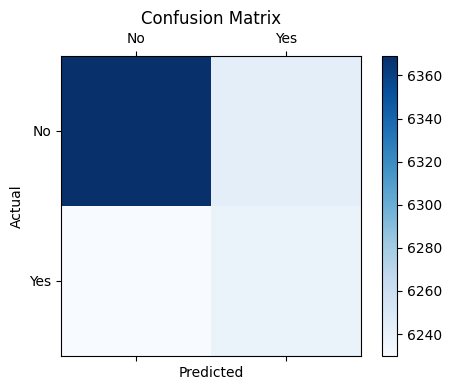

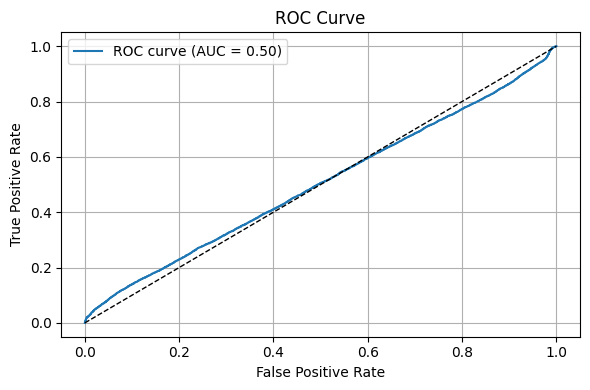

(0.5026712383382506,
 0.5000801538954793,
 np.float64(0.5028008158401391),
 array([[6369, 6244],
        [6230, 6239]]),
 0.4997997276295762,
 0.5003608950196488)

In [ ]:
# 20 symbols, target_1y
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_1y'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


6. train_improved_lstm_classifier_1 VS  train_improved_lstm_classifier_2 for 100 symbols

valores:  target_3m
0    0.734549
1    0.265451
Name: proportion, dtype: float64
Shape before: (622891, 56)
Shape after: (622891, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 116s 14ms/step - accuracy: 0.5041 - auc: 0.5208 - loss: 0.7325 - precision: 0.3975 - recall: 0.5623 - val_accuracy: 0.6482 - val_auc: 0.5542 - val_loss: 0.6532 - val_precision: 0.4079 - val_recall: 0.0810
Epoch 2/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - accuracy: 0.5310 - auc: 0.5384 - loss: 0.6970 - precision: 0.4085 - recall: 0.5038 - val_accuracy: 0.5709 - val_auc: 0.5487 - val_loss: 0.6917 - val_precision: 0.3844 - val_recall: 0.4396
Epoch 3/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 110s 14ms/step - accuracy: 0.5443 - auc: 0.5541 - loss: 0.6899 - precision: 0.4207 - recall: 0.5092 - val_accuracy: 0.6118 - val_auc: 0.5558 - val_loss: 0.6643 - val_precision: 0.3997 - val_recall: 0.2866
Epoch 4/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - accuracy: 0.5560 - auc: 0.5727 - loss: 0.6853 - precision: 0.4348 - recall: 0.5230 - val_accuracy: 0.4508 - val_auc: 0.5604 - val_loss: 0.7204 - val_precision: 0.3601 - val_recall: 0.7961
Epoch 5/40
7

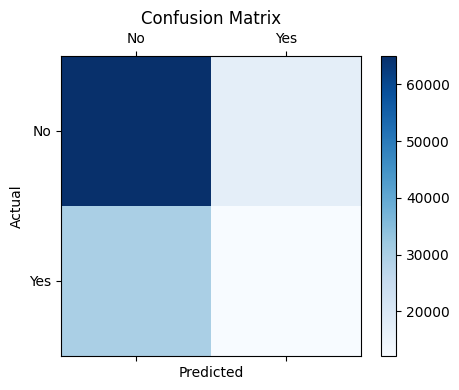

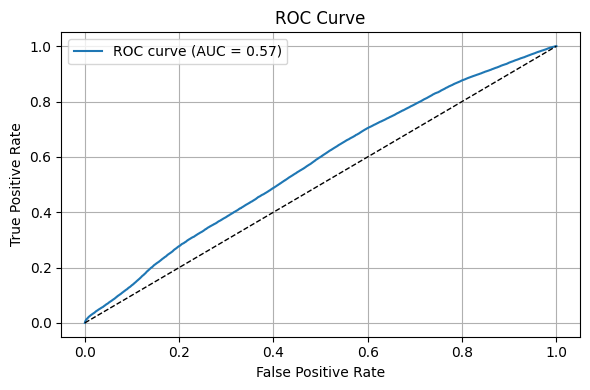

(0.6198029975836297,
 0.3399303135888502,
 np.float64(0.5707494275243373),
 array([[65012, 17282],
        [30078, 12195]]),
 0.4137123859280117,
 0.2884820097934852)

In [ ]:
# 100 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
print("valores: ",df_clean['target_3m'].value_counts(normalize=True))


df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean.to_csv('ejemplo.csv',sep=";")
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (622891, 56)
Shape after: (622891, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 170s 21ms/step - accuracy: 0.5128 - auc: 0.5116 - loss: 0.7853 - precision: 0.3916 - recall: 0.4915 - val_accuracy: 0.5902 - val_auc: 0.5651 - val_loss: 0.6761 - val_precision: 0.3994 - val_recall: 0.4117
Epoch 2/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 164s 21ms/step - accuracy: 0.5137 - auc: 0.5219 - loss: 0.7126 - precision: 0.3977 - recall: 0.5226 - val_accuracy: 0.6208 - val_auc: 0.5631 - val_loss: 0.6740 - val_precision: 0.4191 - val_recall: 0.3041
Epoch 3/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 164s 21ms/step - accuracy: 0.5264 - auc: 0.5388 - loss: 0.6965 - precision: 0.4083 - recall: 0.5250 - val_accuracy: 0.6087 - val_auc: 0.5690 - val_loss: 0.6794 - val_precision: 0.4141 - val_recall: 0.3688
Epoch 4/40
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 164s 21ms/step - accuracy: 0.5412 - auc: 0.5506 - loss: 0.6907 - precision: 0.4189 - recall: 0.5077 - val_accuracy: 0.5698 - val_auc: 0.5678 - val_loss: 0.6871 - val_precision: 0.3921 - val_recall: 0.4862
Epoch 5/40
7

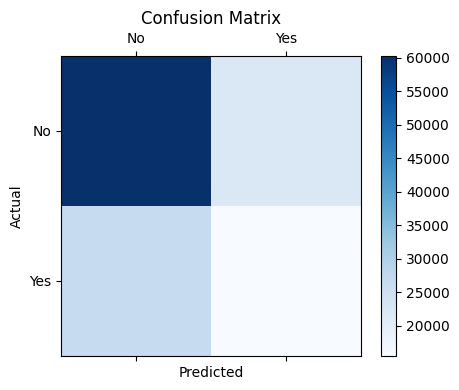

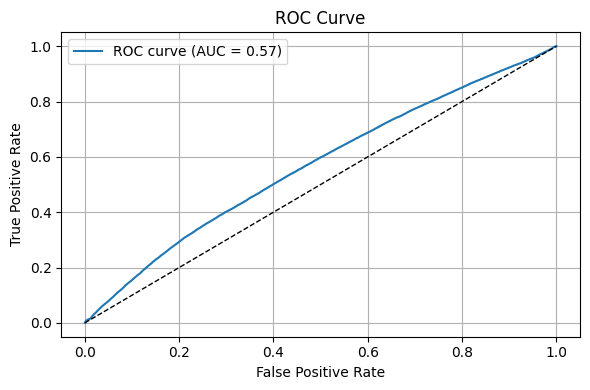

(0.608732649899251,
 0.3901297596256116,
 np.float64(0.5689371729671264),
 array([[60239, 22055],
        [26684, 15589]]),
 0.41411645946233133,
 0.36876966385163107)

In [ ]:
# 100 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


In [ ]:
def build_and_split_sequences_by_symbol(
    df: pd.DataFrame,
    target_column: str,
    sequence_length: int = 60,
    test_size: float = 0.2
):
    """
    Builds sequential data for each symbol independently and performs temporal train-test split.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features and target.
        target_column (str): Column name for binary target.
        sequence_length (int): Time window for each sequence.
        test_size (float): Proportion of test samples (applied per symbol).

    Returns:
        Tuple of numpy arrays: X_train, X_test, y_train, y_test
    """
    X_train, y_train, X_test, y_test = [], [], [], []

    symbols = df["symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")
        df_symbol[target_column] = df_symbol[target_column].astype(int)

        features = df_symbol.drop(columns=["date", "symbol", "target_3m", "target_6m", "target_1y"], errors="ignore").copy()
        target = df_symbol[target_column].values

        for i in range(len(features) - sequence_length):
            X_seq = features.iloc[i:i+sequence_length].values.astype(np.float32)
            y_val = target[i+sequence_length]

            if i + sequence_length < int(len(features) * (1 - test_size)):
                X_train.append(X_seq)
                y_train.append(y_val)
            else:
                X_test.append(X_seq)
                y_test.append(y_val)

    return (
        np.array(X_train),
        np.array(X_test),
        np.array(y_train),
        np.array(y_test)
    )


In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         def prepare_data(
    df: pd.DataFrame,
    targets: list,
    scaler_type: str = 'standard',
    drop_cols: list = ['date', 'symbol'],
    encode_symbol: bool = False
):
    """
    Prepares data for ML models by imputing missing values and scaling features.

    Returns:
        df_scaled: Scaled DataFrame with features + targets + symbol + date
        scaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Preserva símbolo si se codifica
    if encode_symbol and 'symbol' in df_clean.columns:
        drop_cols = [col for col in drop_cols if col != 'symbol']

    # Separar symbol y date antes de limpiar
    symbol_col = df_clean['symbol'] if 'symbol' in df_clean.columns else None
    date_col = df_clean['date'] if 'date' in df_clean.columns else None

    # Eliminar columnas no deseadas
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    df_clean.to_csv("clean_sin_symbol.csv",sep=";")

    # Codificar variables categóricas
    for col in df_clean.select_dtypes(include=['object', 'category']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    # Separar features y targets
    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Escalado
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)

    # Recuperar columnas necesarias
    if symbol_col is not None:
        df_scaled["symbol"] = symbol_col.values
    if date_col is not None:
        df_scaled["date"] = date_col.values

    return df_scaled, scaler

Shape before: (6130, 56)
Shape after: (6130, 30)
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5309 - auc: 0.4869 - loss: 0.9292 - precision: 0.6334 - recall: 0.6322 - val_accuracy: 0.5326 - val_auc: 0.6737 - val_loss: 0.6905 - val_precision: 0.8066 - val_recall: 0.2432
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5461 - auc: 0.5124 - loss: 0.8898 - precision: 0.6425 - recall: 0.6387 - val_accuracy: 0.4780 - val_auc: 0.6867 - val_loss: 0.6920 - val_precision: 0.8795 - val_recall: 0.1038
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5172 - auc: 0.4941 - loss: 0.8983 - precision: 0.6268 - recall: 0.5897 - val_accuracy: 0.4315 - val_auc: 0.6231 - val_loss: 0.7356 - val_precision: 1.0000 - val_recall: 0.0085
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5262 - auc: 0.5137 - loss: 0.8763 - precision: 0.6363 - recall: 0.5939 - val_accuracy: 0.4266 - val_auc: 0.5020 - val_loss: 0.8060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 2

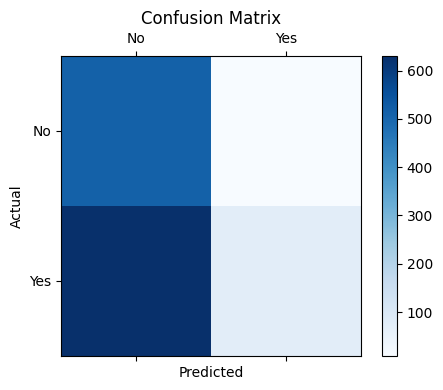

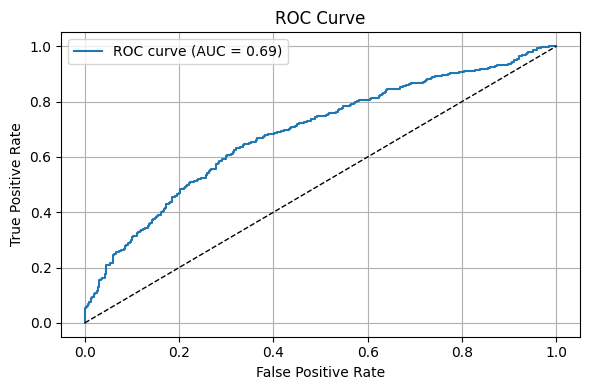

(0.47797716150081565,
 0.18575063613231552,
 np.float64(0.6873981760768517),
 array([[513,  10],
        [630,  73]]),
 0.8795180722891566,
 0.10384068278805121)

In [ ]:
# Filtrado solo de AAPL
df_clean = df_full[df_full["symbol"] == "AAPL"].copy()
df_clean = df_clean.sort_values(by="date")

df_clean.to_csv("1aapl_ordenado.csv",sep=";")


# Guardar columnas necesarias antes de limpiar
symbol_col = df_clean["symbol"].copy()
date_col = df_clean["date"].copy()

# Limpieza con imputación
df_clean = clean_columns(df_clean)

df_clean.to_csv('2aapl_clean.csv', sep=';')


# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets,
    scaler_type='minmax',
    encode_symbol=False  # no hace falta codificar símbolo si solo hay uno
)
df_processed_minmax.to_csv('3aapl_processed.csv', sep=';')

# Reincorporar columnas necesarias
df_processed_minmax["symbol"] = symbol_col.values
df_processed_minmax["date"] = date_col.values

df_processed_minmax.to_csv('4aapl_processed.csv', sep=';')


# Secuenciado correcto
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets,
    scaler_type='minmax',
    encode_symbol=True  # puedes poner False si no quieres incluir symbol
)

# Reincorporar columnas necesarias
df_processed_minmax["symbol"] = df_full.loc[df_clean.index, "symbol"].values
df_processed_minmax["date"] = df_full.loc[df_clean.index, "date"].values

# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


**5. Train target_6m for 500 symbols**

In [ ]:
# 500 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_2(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (3077632, 56)
Shape after: (3077632, 30)
feature_cols:['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95']


KeyboardInterrupt: 

**6. Train train_gru_classifier for 20 symbols**

In [ ]:
#train_base_gru_classifier_lite
#20 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

# Training
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


In [ ]:
#train_base_gru_classifier_lite
#100 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

# Training
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


In [ ]:
#train_base_gru_classifier_lite
#500 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)

# Training
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length
)

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


**7. KERAS TUNER**




In [ ]:
from keras.layers import Flatten, GlobalMaxPooling1D

def train_lstm_with_tuning(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=20,
    max_trials=15,
    executions_per_trial=1,
    tuner_dir="keras_tuner_dir",
    tuner_project="lstm_advanced_tuning",
    epochs=30,
    patience=4,
    batch_size=32
):
    """
    LSTM model training with hyperparameter tuning and multi-layer architecture search.

    Returns:
        best_model, X_test, y_test, y_prob, y_pred
    """
    def build_model(hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int("lstm_units_1", 32, 128, step=32),
            return_sequences=True,
            input_shape=(sequence_length, X_train.shape[2])
        ))
        model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

        return_seq = True

        # Optional second LSTM layer
        if hp.Boolean("use_second_lstm"):
            return_seq = hp.Boolean("second_return_seq")
            model.add(LSTM(
                units=hp.Int("lstm_units_2", 32, 64, step=16),
                return_sequences=return_seq
            ))
            model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

        # Optional third LSTM layer
        if hp.Boolean("use_third_lstm"):
            # If previous layer had return_sequences=True, we keep it
            model.add(LSTM(
                units=hp.Int("lstm_units_3", 32, 64, step=16),
                return_sequences=False  # last LSTM should not return sequences
            ))
            model.add(Dropout(hp.Float("dropout_3", 0.1, 0.5, step=0.1)))
            return_seq = False

        # If last layer still returns sequences, reduce to 2D
        if return_seq:
            model.add(GlobalMaxPooling1D())

        # Optional dense layer
        if hp.Boolean("use_dense"):
            model.add(Dense(hp.Int("dense_units", 16, 64, step=16), activation="relu"))

        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
            ),
            loss=BinaryCrossentropy(),
            metrics=['accuracy', AUC()]
        )
        return model

    tuner = RandomSearch(
        build_model,
        objective="val_auc",
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory=tuner_dir,
        project_name=tuner_project,
        overwrite=True
    )

    early_stop = EarlyStopping(monitor="val_auc", patience=patience, restore_best_weights=True)

    tuner.search(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print("\nBest hyperparameters found:")
    print(best_hp.values)

    y_prob = best_model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return best_model, X_test, y_test, y_prob, y_pred


In [ ]:
#20 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)


model, X_test, y_test, y_prob, y_pred = train_lstm_with_tuning(
    X_train, X_test, y_train, y_test,
    sequence_length,
    max_trials= 15  #
)
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

In [ ]:
#100 symbols, target_6m
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = clean_columns(df_clean)

targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Split
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences(df_processed_minmax, target_column, sequence_length)


model, X_test, y_test, y_prob, y_pred = train_lstm_with_tuning(
    X_train, X_test, y_train, y_test,
    sequence_length,
    max_trials= 8  #
)

model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

In [ ]:
model.save("mejor_modelo_lstm_100symbols.keras")

In [ ]:
from keras.models import load_model

modelo_cargado = load_model("mejor_modelo_lstm_100symbols.keras")


## FULL TRAINING

In [ ]:
def save_trained_model_and_scaler(model, scaler, model_name, target_column, folder_path='/content/drive/MyDrive/modelos_lstm'):
    """
    Save trained LSTM model and corresponding scaler.

    Args:
        model: Trained Keras model object.
        scaler: Fitted scaler (e.g., MinMaxScaler).
        model_name (str): Identifier name for model (e.g. "improved_lstm").
        target_column (str): Target variable name (e.g. "target_6m").
        folder_path (str): Directory path where to save model and scaler.
    """
    import os
    import joblib
    from tensorflow.keras.models import save_model

    os.makedirs(folder_path, exist_ok=True)

    model_path = f"{folder_path}/{model_name}.keras"
    scaler_path = f"{folder_path}/scaler_{model_name}.pkl"

    save_model(model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Modelo guardado en: {model_path}")
    print(f"Scaler guardado en: {scaler_path}")


In [ ]:
def save_probabilities_csv(indices_test,
                           y_prob,
                           y_pred,
                           y_test,
                           base_df,
                           target_column,
                           model_name,
                           folder_path='/content/drive/MyDrive/modelos_lstm'):
    """
    Saves a CSV file with predicted probabilities, predictions, and true labels,
    including metadata such as symbol and date.

    Args:
        indices_test (array-like): Original DataFrame indices corresponding to each X_test row.
        y_prob (array-like): Estimated probabilities for the positive class.
        y_pred (array-like): Final prediction (0/1) per row.
        y_test (array-like): Ground truth label per row.
        base_df (pd.DataFrame): DataFrame used to build sequences (must include 'symbol' and 'date').
        target_column (str): Name of the target variable (e.g., "target_6m").
        model_name (str): Model identifier (e.g., "lstm_base").
        folder_path (str): Output folder for saving results.
    """
    import os
    import pandas as pd

    os.makedirs(folder_path, exist_ok=True)

    assert 'symbol' in base_df.columns and 'date' in base_df.columns, "Missing required columns in base_df"

    base_df = base_df.reset_index(drop=False)

    # Retrieve symbol and date for each test instance
    meta = base_df.loc[indices_test, ['symbol', 'date']].reset_index(drop=True)

    df_out = meta.copy()
    df_out['y_prob'] = y_prob
    df_out['y_pred'] = y_pred
    df_out['y_true'] = y_test

    csv_path = f"{folder_path}/probs_{model_name}_{target_column}.csv"
    df_out.to_csv(csv_path, index=False)
    print(f"Probability CSV saved at: {csv_path}")


In [ ]:
#df_clean = df_full.sort_values(by=["symbol", "date"])
#df_clean = clean_columns(df_clean)
################

#################################
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean = df_clean.reset_index(drop=True)
df_clean = clean_columns(df_clean)
######################################################
################

targets = ['target_3m', 'target_6m', 'target_1y']
sequence_length = 60
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

print("Columnas usadas para entrenamiento (escaladas):", df_processed_minmax.columns.tolist())
print("Total columnas finales:", len(df_processed_minmax.columns))
features = df_processed_minmax.drop(columns=targets).columns.tolist()
joblib.dump(features, f"feature_columns.pkl")


for target_column in targets:
    print(f"\nEntrenando modelo para: {target_column}")

    # Preparar secuencias
    X_train, X_test, y_train, y_test = build_and_split_sequences(
        df_processed_minmax, target_column, sequence_length
    )

    # Entrenar modelo base
    model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        sequence_length=sequence_length
    )

    # Evaluación
    model_evaluation(
        y_test=pd.Series(y_test),
        y_pred=pd.Series(y_pred),
        y_prob=pd.Series(y_prob)
    )

    # Guardar modelo + scaler
    save_trained_model_and_scaler(
        model,
        scaler_minmax,
        model_name=f"lstm_base_{target_column}",
        target_column=target_column
    )
